In [1]:
'''
20251127:
    load llama2的语言神经元&计算ppl
'''

'\n20251127:\n    load llama2的语言神经元&计算ppl\n'

In [1]:
!pip install datasets

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 5.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━

In [2]:
!pip install transformers

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [3]:
!pip install accelerate

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 1.7 MB/s eta 0:00:0000:0100:01


In [63]:
import transformers

import json
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
# download checkpoint
from accelerate import load_checkpoint_and_dispatch
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"  # To prevent long warnings :)

#from accelerate import load_checkpoint_and_dispatch

from accelerate import init_empty_weights
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

import util
import importlib

importlib.reload(util)      # 只能 reload 模块本身
from util import calc_ppl, get_test_data, get_open_ended_answer, get_open_ended_answer_vllm   # reload 后再重新 import 函数

import copy
import datasets

In [2]:
def load_model(checkpoint):
    config = AutoConfig.from_pretrained(checkpoint,trust_remote_code=True)
    print('checkpoint:', checkpoint)
    
    
    if True:
    
        device_map='cuda'
        model= AutoModelForCausalLM.from_pretrained(checkpoint, trust_remote_code=True, torch_dtype= torch.bfloat16,device_map=device_map ) # for download model weight
    
    else:
        with init_empty_weights():
            model = AutoModelForCausalLM.from_config(config, trust_remote_code=True)
    
        model = load_checkpoint_and_dispatch(
            model, checkpoint, device_map="auto", dtype=torch.bfloat16#, no_split_module_classes=["GPTJBlock"]
        )
    
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)#AutoTokenizer.from_pretrained("/home/work/lyftri/projects/model_zoo/compass_sea_13b_s4_merge2HF_org_convert_TP_1_PP_2",  trust_remote_code=True)#AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)

    return model, tokenizer

In [6]:




def get_mask_neuron_model(model, activation_mask_path, need_lang):

    if activation_mask_path:
        activation_masks = torch.load(activation_mask_path)
    else:
        activation_masks = [None]
    
    final_output = []
    if is_llama:
        languages = ["en", "zh", "fr", "es", "vi", "id", "ja"]
    else:
        languages = ["en", "zh", "fr", "es", "vi", "id"]
    
    need_lang = [need_lang]#['en', 'zh', 'vi']
    
    for activation_mask, mask_lang in zip(activation_masks, languages):
    
        if mask_lang not in need_lang:continue
            
        print(f'get mask =====lang:{mask_lang}=====')
    
        
        if activation_mask:
            def factory(mask):
                def llama_forward_org(self, x):
                    gate_up, _ = self.gate_up_proj(x)  # b, l, 2i
                    i = gate_up.size(-1)
                    activation = F.silu(gate_up[:, :, : i // 2])
                    activation.index_fill_(2, mask, 0)
                    x = activation * gate_up[:, :, i // 2 :]
                    x, _ = self.down_proj(x)
                    return x
                def llama_forward(self, x):
                    gate_ = self.gate_proj(x)  # b, l, 2i
                    i = gate_.size(-1)
                    activation = F.silu(gate_)
                    activation.index_fill_(2, mask, 0)
                    x = activation * self.up_proj(x)
                    x = self.down_proj(x)
                    return x
    
                def bloom_forward(self, x: torch.Tensor):
                    x, _ = self.dense_h_to_4h(x)
                    x = self.gelu_impl(x)
                    x.index_fill_(2, mask, 0)
                    x, _ = self.dense_4h_to_h(x)
                    return x
    
                if is_llama:
                    return llama_forward
                else:
                    return bloom_forward
    
            for i, layer_mask in enumerate(activation_mask):
                if is_llama:
                    obj = model.model.layers[i].mlp
                else:
                    obj = model.model.layers[i].mlp
                obj.forward = MethodType(factory(layer_mask.to('cuda')), obj)
    return model








def get_mask_neuron_model_vllm(model, activation_mask_path, need_lang):

    if activation_mask_path:
        activation_masks = torch.load(activation_mask_path)
    else:
        activation_masks = [None]
    
    final_output = []
    if is_llama:
        languages = ["en", "zh", "fr", "es", "vi", "id", "ja"]
    else:
        languages = ["en", "zh", "fr", "es", "vi", "id"]
    
    need_lang = [need_lang]#['en', 'zh', 'vi']
    
    for activation_mask, mask_lang in zip(activation_masks, languages):
    
        if mask_lang not in need_lang:continue
            
        print(f'get mask =====lang:{mask_lang}=====')
    
        
        if activation_mask:
            def factory(mask):
                def llama_forward(self, x):
                    gate_up, _ = self.gate_up_proj(x)  # b, l, 2i
                    i = gate_up.size(-1)
                    activation = F.silu(gate_up[:, :, : i // 2])
                    activation.index_fill_(2, mask, 0)
                    x = activation * gate_up[:, :, i // 2 :]
                    x, _ = self.down_proj(x)
                    return x
                def llama_forward_split(self, x):
                    gate_ = self.gate_proj(x)  # b, l, 2i
                    i = gate_.size(-1)
                    activation = F.silu(gate_)
                    #activation.index_fill_(2, mask, 0)

                    # test
                    print(activation.shape)
                    activation.index_fill_(2, torch.tensor(list(range(activation.shape[1]))), 0 )
                    x = activation * self.up_proj(x)
                    x = self.down_proj(x)
                    return x
    
                def bloom_forward(self, x: torch.Tensor):
                    x, _ = self.dense_h_to_4h(x)
                    x = self.gelu_impl(x)
                    x.index_fill_(2, mask, 0)
                    x, _ = self.dense_4h_to_h(x)
                    return x
    
                if is_llama:
                    return llama_forward
                else:
                    return bloom_forward
    
            for i, layer_mask in enumerate(activation_mask): 
                #print('ilayer:',i, layer_mask)
                #if is_llama:
                    # latest
                    #obj = model.llm_engine.model_executor.driver_worker.model_runner.model.model.layers[i].mlp
                #else:
                    # latest
                    #obj = model.llm_engine.model_executor.driver_worker.model_runner.model.transformer.h[i].mlp

                if is_llama:
                    obj = model.llm_engine.driver_worker.model_runner.model.model.layers[i].mlp
                else:
                    obj = model.llm_engine.driver_worker.model_runner.model.transformer.h[i].mlp
                obj.forward = MethodType(factory(layer_mask.to('cuda')), obj)
    return model

In [4]:
import os
os.environ["VLLM_ENABLE_V1_MULTIPROCESSING"] = "0"

In [5]:
import argparse
from types import MethodType

import numpy as np
import torch
import torch.nn.functional as F
from vllm import LLM, SamplingParams
from tqdm import tqdm



model_path ='/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-chat-hf'
activation_mask_path='/root/autodl-fs/Language-Specific-Neurons/LLaMA-2-7B.neuron.pth'

is_llama = bool(model_path.find('llama') >= 0)
#model, tokenizer = load_model(model_path)

# 初始化 vLLM
llm =LLM(model=model_path, tensor_parallel_size=torch.cuda.device_count(), enforce_eager=True) #LLM(model=model_path, tensor_parallel_size=1)




INFO 12-02 14:11:03 llm_engine.py:70] Initializing an LLM engine with config: model='/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-chat-hf', tokenizer='/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-chat-hf', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, quantization=None, enforce_eager=True, seed=0)
INFO 12-02 14:13:31 llm_engine.py:275] # GPU blocks: 1911, # CPU blocks: 512


## test ppl

In [6]:
# load test data
test_en = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/en_radom_1000_test.jsonl')
test_vi = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/vi_radom_1000_test.jsonl')
test_zh = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/zh_radom_1000_test.jsonl')
               
# calc ppl
model_list= [
    (model, 'org_model'),
    (None, 'mask_en'),
    (None, 'mask_vi'),
    (None, 'mask_zh'),
]

data_list = [
    (test_en, 'en_data'),
    (test_vi, 'vi_data'),
    (test_zh, 'zh_data')
    
]

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    if model_name != 'org_model':
        i_model = get_mask_neuron_model(model, activation_mask_path, model_name.split('_')[-1])

    for i_data, data_name in data_list:
        print('='*20)
        print('data name:', data_name)
        ppl_sum, ppl_count = calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        print('ppl:',ppl_sum/ppl_count )





********************
********************
model name: org_model
data name: en_data


100%|██████████| 1000/1000 [00:53<00:00, 18.75it/s]


ppl: tensor(11.5736, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [02:21<00:00,  7.09it/s]


ppl: tensor(14.1997, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [01:39<00:00, 10.02it/s]


ppl: tensor(11.3294, device='cuda:0')
********************
********************
model name: mask_en
get mask =====lang:en=====
data name: en_data


100%|██████████| 1000/1000 [00:53<00:00, 18.86it/s]


ppl: tensor(11.5102, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [02:20<00:00,  7.10it/s]


ppl: tensor(13.7195, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [01:39<00:00, 10.02it/s]


ppl: tensor(11.0321, device='cuda:0')
********************
********************
model name: mask_vi
get mask =====lang:vi=====
data name: en_data


100%|██████████| 1000/1000 [00:53<00:00, 18.86it/s]


ppl: tensor(11.5556, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [02:20<00:00,  7.10it/s]


ppl: tensor(12.9547, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [01:39<00:00, 10.02it/s]


ppl: tensor(10.6875, device='cuda:0')
********************
********************
model name: mask_zh
get mask =====lang:zh=====
data name: en_data


100%|██████████| 1000/1000 [00:53<00:00, 18.86it/s]


ppl: tensor(11.3950, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [02:20<00:00,  7.10it/s]


ppl: tensor(13.4718, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [01:39<00:00, 10.01it/s]

ppl: tensor(10.2067, device='cuda:0')


In [8]:
# load test data
test_en = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/en_radom_1000_test.jsonl')
test_vi = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/vi_radom_1000_test.jsonl')
test_zh = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/zh_radom_1000_test.jsonl')
               
# calc ppl
model_list= [
    (model, 'org_model'),
    #(None, 'mask_en'),
    #(None, 'mask_vi'),
    (None, 'mask_zh'),
]

data_list = [
    (test_en, 'en_data'),
    (test_vi, 'vi_data'),
    (test_zh, 'zh_data')
    
]

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    if model_name != 'org_model':
        i_model = get_mask_neuron_model(model, activation_mask_path, model_name.split('_')[-1])

    for i_data, data_name in data_list:
        print('='*20)
        print('data name:', data_name)
        ppl_sum, ppl_count = calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        print('ppl:',ppl_sum/ppl_count )





********************
********************
model name: org_model
data name: en_data


100%|██████████| 1000/1000 [00:52<00:00, 18.93it/s]


ppl: tensor(11.5736, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [02:21<00:00,  7.09it/s]


ppl: tensor(14.1997, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [01:39<00:00, 10.03it/s]


ppl: tensor(11.3294, device='cuda:0')
********************
********************
model name: mask_zh
get mask =====lang:zh=====
data name: en_data


100%|██████████| 1000/1000 [00:53<00:00, 18.83it/s]


ppl: tensor(11.3950, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [02:20<00:00,  7.10it/s]


ppl: tensor(13.4718, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [01:39<00:00, 10.01it/s]

ppl: tensor(10.2067, device='cuda:0')


## test open ended

In [5]:
llm

In [22]:
# load test data
ds_test = datasets.load_dataset('json', data_files ='/root/autodl-fs/LRP/open_ended_dataset/all_data.json')
               
# calc ppl
model_list= [
    (llm, 'org_model'),
    (None, 'mask_en'),
    (None, 'mask_vi'),
    (None, 'mask_zh'),
]

data_list = [
    (ds_test, 'open_ended')    
]

ds_list = []

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    if model_name != 'org_model':
        i_model = get_mask_neuron_model_vllm(llm, activation_mask_path, model_name.split('_')[-1])


    for i_data, data_name in data_list:
        ds_test_tmp = copy.deepcopy(i_data)
        print('='*20)
        print('data name:', data_name)
        
        ans_list= get_open_ended_answer_vllm(i_model, list(ds_test_tmp['train']['text']))#calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        # create model -col
        model_describe = [model_name+'|'+data_name]*len(ans_list)
        
        #ds_test['train'] = ds_test['train'].add_column(name='describ'+('|'+model_name+'|'+data_name), column=model_describe)        
        ds_test_tmp['train'] = ds_test_tmp['train'].add_column(name='answer', column=ans_list)   

        ds_test_tmp['train'] = ds_test_tmp['train'].add_column(name='model_type', column=model_describe)      

        ds_list.append(ds_test_tmp['train'])
        
# 
ds_final = datasets.concatenate_datasets(ds_list)
ds_final.to_json('~/autodl-fs/LRP/open_ended_data_generation/20251201_LAPE_org_generation.json', force_ascii=False)



********************
********************
model name: org_model
data name: open_ended
********************


Processed prompts: 100%|██████████| 210/210 [02:23<00:00,  1.47it/s]


********************
********************
model name: mask_en
get mask =====lang:en=====
data name: open_ended
********************


Processed prompts: 100%|██████████| 210/210 [01:55<00:00,  1.82it/s]


********************
********************
model name: mask_vi
get mask =====lang:vi=====
data name: open_ended
********************


Processed prompts: 100%|██████████| 210/210 [01:48<00:00,  1.94it/s]


********************
********************
model name: mask_zh
get mask =====lang:zh=====
data name: open_ended
********************


Processed prompts: 100%|██████████| 210/210 [02:23<00:00,  1.47it/s]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2196212

In [24]:
df_final = ds_final.to_pandas()

In [25]:
ds_final.head(2)

,text,lang,__index_level_0__,answer,model_type
0,How can I improve my time management skills?,en,0,Time management is the process of planning and...,org_model|open_ended
1,What are the most effective ways to deal with ...,en,1,Stress is a natural response of the body to ch...,org_model|open_ended


In [27]:
df_final = ds_final

In [28]:
df_final['model_type'].value_counts()

model_type
org_model|open_ended    210
mask_en|open_ended      210
mask_vi|open_ended      210
mask_zh|open_ended      210
Name: count, dtype: int64

In [29]:
df_final.head(2)

,text,lang,__index_level_0__,answer,model_type
0,How can I improve my time management skills?,en,0,Time management is the process of planning and...,org_model|open_ended
1,What are the most effective ways to deal with ...,en,1,Stress is a natural response of the body to ch...,org_model|open_ended


In [34]:
df_final['answer'][210] == df_final['answer'][0]

False

In [51]:
'''
生成judge的prompt

'''

prompt_template = (
    "You are a neutral judge. Score the model’s answer from 1 to 10 based on correctness, completeness, clarity, and usefulness.\n"
    "Respond ONLY in this JSON format:\n"
    '{{"score": <1-10>, "reason": "<brief reason>"}}\n\n'
    "Question:\n{question}\n\n"
    "Answer:\n{answer}"
)

def get_judge_promt(x):
    return prompt_template.format(question= x[0], answer= x[1])
    

In [52]:
df_final['judge_prompt'] = df_final[['text','answer']].apply(lambda x: prompt_template.format(question= x[0], answer= x[1]), axis=1)


/tmp/ipykernel_952/3206873007.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_final['judge_prompt'] = df_final[['text','answer']].apply(lambda x: prompt_template.format(question= x[0], answer= x[1]), axis=1)


In [53]:
df_final.head(2)

,text,lang,__index_level_0__,answer,model_type,judge_prompt
0,How can I improve my time management skills?,en,0,Time management is the process of planning and...,org_model|open_ended,You are a neutral judge. Score the model’s ans...
1,What are the most effective ways to deal with ...,en,1,Stress is a natural response of the body to ch...,org_model|open_ended,You are a neutral judge. Score the model’s ans...


In [55]:
print(df_final['judge_prompt'][0])

You are a neutral judge. Score the model’s answer from 1 to 10 based on correctness, completeness, clarity, and usefulness.
Respond ONLY in this JSON format:
{"score": <1-10>, "reason": "<brief reason>"}

Question:
How can I improve my time management skills?

Answer:
Time management is the process of planning and controlling the amount of time spent on different activities to maximize efficiency and productivity. Here are some tips that can help you improve your time management skills:

1. Set clear goals: Setting clear goals helps you prioritize tasks and allocate your time effectively. Make sure your goals are specific, measurable, achievable, relevant, and time-bound (SMART).
2. Create a schedule: Plan out your day, week, or month in advance using a calendar or planner. Schedule fixed and flexible tasks, and make sure to include time for breaks and relaxation.
3. Prioritize tasks: Determine which tasks are most important and need to be completed first. Use the Eisenhower Matrix to 

In [56]:
ds_final = datasets.Dataset.from_pandas(df_final)

In [57]:
ds_final.to_json('~/autodl-fs/LRP/open_ended_data_generation/20251201_LAPE_org_generation4judge.json',index=False)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

4772282

## load judege resulst

In [59]:
ds_judge_res = datasets.load_dataset('json', data_files = '/root/autodl-fs/LRP/open_ended_data_generation/20251201_LAPE_org_generation4judge.json_gpt4o.json')




Generating train split: 0 examples [00:00, ? examples/s]

In [60]:
df_judge_res = ds_judge_res['train'].to_pandas()

In [61]:
df_judge_res.head(2)

,text,lang,__index_level_0__,answer,model_type,judge_prompt,output
0,How can I improve my time management skills?,en,0,Time management is the process of planning and...,org_model|open_ended,You are a neutral judge. Score the model’s ans...,"{""score"": 9, ""reason"": ""The answer is comprehe..."
1,What are the most effective ways to deal with ...,en,1,Stress is a natural response of the body to ch...,org_model|open_ended,You are a neutral judge. Score the model’s ans...,"{""score"": 9, ""reason"": ""The answer is comprehe..."


In [65]:
# get score
def get_score(x):
    try:
        return  json.loads(x)['score']
    except:
        return -1

df_judge_res['score'] = df_judge_res['output'].apply(get_score)

In [66]:
df_judge_res.head()

,text,lang,__index_level_0__,answer,model_type,judge_prompt,output,score
0,How can I improve my time management skills?,en,0,Time management is the process of planning and...,org_model|open_ended,You are a neutral judge. Score the model’s ans...,"{""score"": 9, ""reason"": ""The answer is comprehe...",9
1,What are the most effective ways to deal with ...,en,1,Stress is a natural response of the body to ch...,org_model|open_ended,You are a neutral judge. Score the model’s ans...,"{""score"": 9, ""reason"": ""The answer is comprehe...",9
2,What are the main differences between Python a...,en,2,Python and JavaScript are two popular programm...,org_model|open_ended,You are a neutral judge. Score the model’s ans...,"{""score"": 7, ""reason"": ""The answer provides a ...",7
3,How can I increase my productivity while worki...,en,3,Here are some tips to help you increase your p...,org_model|open_ended,You are a neutral judge. Score the model’s ans...,"{""score"": 9, ""reason"": ""The answer is correct,...",9
4,Can you explain the basics of quantum computing?,en,4,Quantum computing is a rapidly growing field t...,org_model|open_ended,You are a neutral judge. Score the model’s ans...,"{""score"": 9, ""reason"": ""The answer provides a ...",9


In [74]:
df_judge_res['class_tpye'] = df_judge_res['lang']+'|' + df_judge_res['model_type']

In [75]:
df_judge_res['class_tpye'].value_counts()

class_tpye
en|org_model|open_ended    70
vi|org_model|open_ended    70
zh|org_model|open_ended    70
en|mask_en|open_ended      70
vi|mask_en|open_ended      70
zh|mask_en|open_ended      70
en|mask_vi|open_ended      70
vi|mask_vi|open_ended      70
zh|mask_vi|open_ended      70
en|mask_zh|open_ended      70
vi|mask_zh|open_ended      70
zh|mask_zh|open_ended      70
Name: count, dtype: int64

In [76]:
result_dict = {}
for imodel_type in list(df_judge_res['class_tpye'].value_counts().keys()):
    print('='*20)
    print('imodel_type:', imodel_type)
    df_tmp = df_judge_res.loc[df_judge_res['class_tpye'] == imodel_type].reset_index(drop=True)
    df_tmp = df_tmp.loc[df_tmp['score']!=-1].reset_index(drop=True)
    print('valid count:', len(df_tmp))
    result_dict[imodel_type] = df_tmp['score'].mean()
          

    
    

    

imodel_type: en|org_model|open_ended
valid count: 70
imodel_type: vi|org_model|open_ended
valid count: 70
imodel_type: zh|org_model|open_ended
valid count: 70
imodel_type: en|mask_en|open_ended
valid count: 70
imodel_type: vi|mask_en|open_ended
valid count: 70
imodel_type: zh|mask_en|open_ended
valid count: 70
imodel_type: en|mask_vi|open_ended
valid count: 69
imodel_type: vi|mask_vi|open_ended
valid count: 70
imodel_type: zh|mask_vi|open_ended
valid count: 69
imodel_type: en|mask_zh|open_ended
valid count: 69
imodel_type: vi|mask_zh|open_ended
valid count: 70
imodel_type: zh|mask_zh|open_ended
valid count: 70


In [77]:
result_dict

{'en|org_model|open_ended': 8.1,
 'vi|org_model|open_ended': 7.314285714285714,
 'zh|org_model|open_ended': 6.7,
 'en|mask_en|open_ended': 7.942857142857143,
 'vi|mask_en|open_ended': 7.128571428571429,
 'zh|mask_en|open_ended': 6.985714285714286,
 'en|mask_vi|open_ended': 7.942028985507246,
 'vi|mask_vi|open_ended': 7.314285714285714,
 'zh|mask_vi|open_ended': 7.072463768115942,
 'en|mask_zh|open_ended': 8.0,
 'vi|mask_zh|open_ended': 7.314285714285714,
 'zh|mask_zh|open_ended': 6.685714285714286}

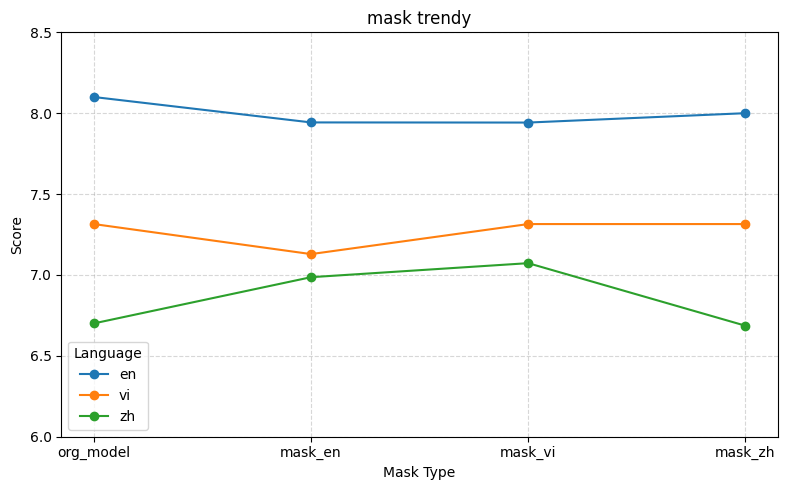

In [79]:
import matplotlib.pyplot as plt

# 数据
data = {
    'en|org_model|open_ended': 8.1,
    'vi|org_model|open_ended': 7.314285714285714,
    'zh|org_model|open_ended': 6.7,
    'en|mask_en|open_ended': 7.942857142857143,
    'vi|mask_en|open_ended': 7.128571428571429,
    'zh|mask_en|open_ended': 6.985714285714286,
    'en|mask_vi|open_ended': 7.942028985507246,
    'vi|mask_vi|open_ended': 7.314285714285714,
    'zh|mask_vi|open_ended': 7.072463768115942,
    'en|mask_zh|open_ended': 8.0,
    'vi|mask_zh|open_ended': 7.314285714285714,
    'zh|mask_zh|open_ended': 6.685714285714286
}

languages = ['en', 'vi', 'zh']
masks = ['org_model', 'mask_en', 'mask_vi', 'mask_zh']

# 构建每个语种的分数序列
scores = {lang: [data[f"{lang}|{mask}|open_ended"] for mask in masks] for lang in languages}

# 画折线图
plt.figure(figsize=(8,5))
for lang in languages:
    plt.plot(masks, scores[lang], marker='o', label=lang)

plt.ylim(6, 8.5)
plt.xlabel("Mask Type")
plt.ylabel("Score")
plt.title("mask trendy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Language")
plt.tight_layout()
plt.show()


In [19]:
'''
# load test data
ds_test = datasets.load_dataset('json', data_files ='/root/autodl-fs/LRP/open_ended_dataset/all_data.json')
               
# calc ppl
model_list= [
    (model, 'org_model'),
    (None, 'mask_en'),
    (None, 'mask_vi'),
    (None, 'mask_zh'),
]

data_list = [
    (ds_test, 'open_ended')    
]

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    if model_name != 'org_model':
        i_model = get_mask_neuron_model(model, activation_mask_path, model_name.split('_')[-1])

    for i_data, data_name in data_list:
        print('='*20)
        print('data name:', data_name)
        
        ans_list= get_open_ended_answer(i_model, tokenizer, list(i_data['train']['text']))#calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        # create model -col
        model_describe = [model_name+'|'+data_name]*len(ans_list)
        
        ds_test['train'].add_column(name='describ', column=model_describe)        
        ds_test['train'].add_column(name='ans', column=ans_list)        

ds_test.to_json('autodl-fs/LRP/open_ended_data_generation/20251201_LAPE_org_generation.json', force_ascii=False)

'''

"\n# load test data\nds_test = datasets.load_dataset('json', data_files ='/root/autodl-fs/LRP/open_ended_dataset/all_data.json')\n               \n# calc ppl\nmodel_list= [\n    (model, 'org_model'),\n    (None, 'mask_en'),\n    (None, 'mask_vi'),\n    (None, 'mask_zh'),\n]\n\ndata_list = [\n    (ds_test, 'open_ended')    \n]\n\nfor i_model, model_name in model_list:\n    print('*'*20)\n    print('*'*20)\n    print('model name:', model_name)\n\n    if model_name != 'org_model':\n        i_model = get_mask_neuron_model(model, activation_mask_path, model_name.split('_')[-1])\n\n    for i_data, data_name in data_list:\n        print('='*20)\n        print('data name:', data_name)\n        \n        ans_list= get_open_ended_answer(i_model, tokenizer, list(i_data['train']['text']))#calc_ppl(i_model, tokenizer, i_data, max_len= 2048)\n        # create model -col\n        model_describe = [model_name+'|'+data_name]*len(ans_list)\n        \n        ds_test['train'].add_column(name='describ', c